In [4]:
import illustris_python as il
import numpy as np
from astropy.cosmology import Planck15
import pymysql

def query_lauca(dbcmd):
    '''Query database and return results as numpy array.'''
    cnf_path = '/home/bottrell/.mysql/lauca.cnf' ### <== Change to yours
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell', ### <== Change to yours 
                         database='IllustrisTNG100_1',
                         read_default_file=cnf_path)
    c = db.cursor()
    c.execute(dbcmd)
    data = np.asarray(c.fetchall())
    c.close()
    db.close()
    return data

def MaxPastMassInRad(basePath,SnapNum,SubfindID,partType='stars',branchLim=4,index=0):
    """Given snap,sub obtain the maximum SubhaloMassInRadType_{partType} in the subhalo's
    subLink merger tree within [branchLim] snapshots (including the subhalo's snapshot)."""
    ptNum = il.snapshot.partTypeNum(partType)
    fields = ['SubfindID','SnapNum']
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassInRadType']
    fields += reqFields
    tree = il.sublink.loadTree(basePath,SnapNum,SubfindID,fields=fields)
    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID = tree['FirstProgenitorID'][index]
    if branchLim == None:
        branchSize = tree['MainLeafProgenitorID'][index] - tree['SubhaloID'][index] + 1
    else:
        branchSize = branchLim
    if fpID!=-1:
        print(f'MPB Snap History: {tree["SnapNum"][index: index + branchSize]}')
        print(f'MPB Sub History: {tree["SubfindID"][index: index + branchSize]}')
        return tree['SubhaloMassInRadType'][index: index + branchSize, ptNum]
    else: 
        return None


def main():
    
    # get Masses and flags for subs from TNG100-1 
    
    sim_tag = 'TNG100-1'
    basePath = f'/project/rrg-jfncc/Illustris-TNG/SimData/{sim_tag}/output'
    snap = 50

    ptNumStars = il.snapshot.partTypeNum('stars') 
    fields = ['SubhaloMassInRadType','SubhaloFlag']
    subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)
    
    little_h = Planck15.H0.value/100.

    SubfindIDs = np.arange(subhalos['count'],dtype=int)
    Mstar_0 = subhalos['SubhaloMassInRadType'][:,ptNumStars]
    flags = subhalos['SubhaloFlag']

    # eliminate non-cosmological "halos" 
    # pick a mass range commensurate with DB
    SubfindIDs = SubfindIDs[(flags!=0)*(Mstar_0>=1.)]
    
    # print out stats for a handful of subs
    for sub in SubfindIDs[1000:1010]:
        print(f'Snap: {snap}, Sub: {sub}')
        Mstar = MaxPastMassInRad(basePath,snap,sub)
        print(f'MPB SubhaloMassInRadType_stars History: {Mstar}')
        print(f'My calculations, Mstar: {np.max(Mstar)}')
        dbcmd = f'SELECT Mstar FROM Environment where snapNum={snap} and subfindID={sub}'
        Mstar_db = query_lauca(dbcmd)[0][0]
        Mstar_db = 10**Mstar_db * little_h/1e10
        print(f'Environment Table, Mstar: {Mstar_db}')
        dbcmd = f'SELECT SubhaloMassInRadType_stars FROM MassRad where snapNum={snap} and subfindID={sub}'
        MassRad_db = query_lauca(dbcmd)[0][0]
        MassRad_db = 10**MassRad_db * little_h/1e10
        print(f'MassRad Table, SubhaloMassInRadType_stars: {MassRad_db}')
        print(f'Ratio:{np.max(Mstar)/Mstar_db}')
        print('')
        

if __name__=='__main__':
    
    main()



Snap: 50, Sub: 166212
MPB Snap History: [50 49 48 47]
MPB Sub History: [166212 162234 159197 150126]
MPB SubhaloMassInRadType_stars History: [1.4594021 1.3904247 1.2836092 1.158041 ]
My calculations, Mstar: 1.459402084350586
Environment Table, Mstar: 1.881244279388272
MassRad Table, SubhaloMassInRadType_stars: 1.459302049157628
Ratio:0.775764264290623

Snap: 50, Sub: 166214
MPB Snap History: [50 49 48 47]
MPB Sub History: [166214 162236 159199 150128]
MPB SubhaloMassInRadType_stars History: [1.4208711 1.3890618 1.3670036 1.3240925]
My calculations, Mstar: 1.4208711385726929
Environment Table, Mstar: 1.742790533667905
MassRad Table, SubhaloMassInRadType_stars: 1.4208400565566643
Ratio:0.8152850908492741

Snap: 50, Sub: 166487
MPB Snap History: [50 49 48 47]
MPB Sub History: [166487 163694 160060 156089]
MPB SubhaloMassInRadType_stars History: [3.534318  3.5205603 3.5208523 3.5099916]
My calculations, Mstar: 3.534317970275879
Environment Table, Mstar: 5.577572090893446
MassRad Table, Sub

Text(0, 0.5, 'log(SFR)')

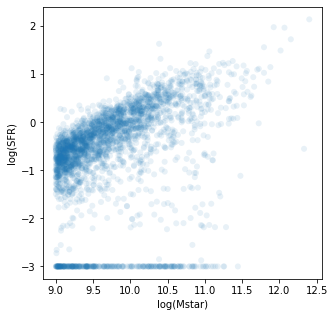

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_dir = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/'
cat_dir = f'{base_dir}/postprocessing/Catalogues'
cat_name = f'{cat_dir}/TNG50-1_072_Catalogue.csv'

df = pd.read_csv(cat_name)

fig,ax=plt.subplots(figsize=(5,5))

sfr = np.maximum(np.log10(df['SubhaloSFRinRad']),-3)

ax.scatter(df['SubhaloMassType_stars'],sfr,alpha=0.1,lw=0,ec='None')

ax.set_xlabel('log(Mstar)')

ax.set_ylabel('log(SFR)')
